# Data cleaning
- This notebook is dedicated to cleaning the data of fatal police shootings in the US. 
- First source of dataset was found at Kaggle: https://www.kaggle.com/datasets/washingtonpost/police-shootings/data
- Data is retrieved from Washington Post GitHub page: https://github.com/washingtonpost/data-police-shootings
- Washington Post GitHub contains Version 1 and Version 2. Version 1 was found at Kaggle.
- Version 2 of the dataset is used, since it contains data for longer period and some features are updated.

## Location data imputing
- Location data is missing the dataset. 
- Features that contain NaN values are investigated and fixed in this notebook.
- Geocoding method is used to determine missing features in this dataset.
- Dataset with mined features is saved as new csv file.

In [1]:
# %load_ext pycodestyle_magic

In [2]:
# %pycodestyle_on

In [3]:
# Necessary libraries are imported
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
from tqdm.notebook import tqdm
import csv
import os

In [4]:
# Jupyter notebook extensions are enabled
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
# Loading dataframe 
file_path = ("/Users/agnekrupinskaite/"
             "PycharmProjects/agkrupi-DWWP.4.1/"
             "Data_sources/fatal-police-shootings-data.csv")
shooting_data = pd.read_csv(file_path, index_col=0, header=0)
shooting_data.head()

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
id,,,,,,,,,,,,,,,,,,
3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


## Location features evaluation
Location features have some missing value:
- The county column has 4731 of NaN values.
- The latitude column has 1034 of NaN values.
- The longitude column has 1034 of NaN values.
- The location_precision column has 1034 of NaN values.
- The city column has 71 of NaN values.
- The state column has 0 of NaN values.

After checking datatypes of location related features no datatypes were changed.

In [6]:
# Counting how many NaN values in each column
shooting_columns_nulls = shooting_data.isnull().sum().sort_values(
    ascending=False)
shooting_columns_nulls

county                        4731
flee_status                   1282
race                          1171
race_source                   1141
location_precision            1034
latitude                      1034
longitude                     1034
age                            388
name                           352
armed_with                     212
city                            71
threat_type                     67
gender                          25
was_mental_illness_related       0
body_camera                      0
date                             0
state                            0
agency_ids                       0
dtype: int64

In [7]:
# Printing each location related feature NaN count
for column, column_data in shooting_columns_nulls[["county",
                                                   "latitude",
                                                   "longitude",
                                                   "location_precision",
                                                   "city",
                                                   "state"]].items():
    print(f"The {column} column has {column_data} of NaN values.")

The county column has 4731 of NaN values.
The latitude column has 1034 of NaN values.
The longitude column has 1034 of NaN values.
The location_precision column has 1034 of NaN values.
The city column has 71 of NaN values.
The state column has 0 of NaN values.


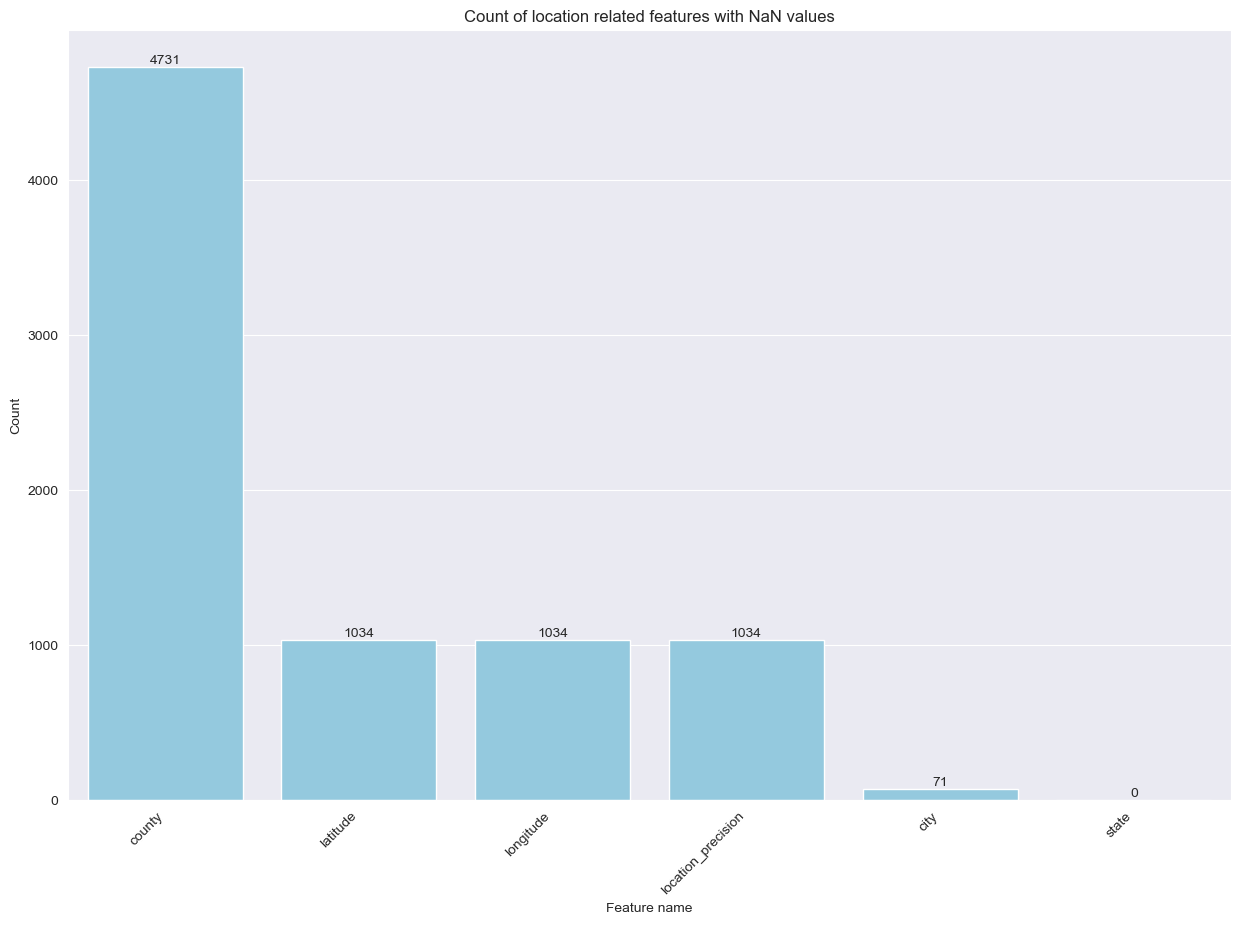

In [8]:
# Plotting NaN values found in different location related features
plt.figure(figsize=(15, 10))
sns.barplot(shooting_columns_nulls[["county",
                                    "latitude",
                                    "longitude",
                                    "location_precision",
                                    "city",
                                    "state"]], color="skyblue")
plt.title("Count of location related features with NaN values")
plt.xlabel("Feature name")
plt.ylabel("Count")
plt.xticks(rotation=45, horizontalalignment="right")

# Adding labels to bars
for i, v in enumerate(shooting_columns_nulls[["county",
                                              "latitude",
                                              "longitude",
                                              "location_precision",
                                              "city",
                                              "state"]].values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()

- The barplot shows that the most values are missing in the county feature. 
- Same amount of values are missing in the latitude, longitude and location_precision features. This allows to make an assumption that these features are related.
- City is missing the lowest amount of values.
- No values are missing in the state feature.

In [9]:
# Checking if location related features data types are correct
shooting_data[["county",
               "latitude",
               "longitude",
               "location_precision",
               "city", "state"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9378 entries, 3 to 10150
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   county              4647 non-null   object 
 1   latitude            8344 non-null   float64
 2   longitude           8344 non-null   float64
 3   location_precision  8344 non-null   object 
 4   city                9307 non-null   object 
 5   state               9378 non-null   object 
dtypes: float64(2), object(4)
memory usage: 512.9+ KB


## Missing location values identification
- Latitude and longitude are the most accurate location features, providing precise coordinates for a specific point on the Earth's surface. Next would be city. The least precise is county and state values.
- Latitude and longitude can be retrieved from county and city values. In this case new location_precision value will also be applied (county_based or city_based).
- City can be found using latitude and longitude. 

### Retrieving latitude and longitude values
- Latitude and longitude are retrieved from city, using geocoding approach.
- New location precision feature is created for features that latitude and longitude are retrieved using city information. These location_precision fields are filled with string city_based.

In [10]:
# Identifying rows with missing latitude, longitude, city, county
lat_long_city_county = ['latitude', 'longitude', "county", "city"]
no_lat_long_city_county = shooting_data[
    shooting_data[lat_long_city_county].isnull().all(axis=1)]
no_lat_long_city_county

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
id,,,,,,,,,,,,,,,,,,


There are no observations that have city, county, latitude and longitude missing. County and city can be used to retrieve latitude and longitude.

In [11]:
# Function to write error to csv
def write_error_to_csv(error_message,
                       directory='.',
                       file_name='error_log.csv'):
    file_path = os.path.join(directory, file_name)
    with open(file_path, mode='a', newline='') as error_file:
        error_writer = csv.writer(error_file)
        error_writer.writerow([error_message])

In [12]:
# Defining the function to retrieve latitude and longitude from county
def get_lat_long_county(county_name):
    """Function retrieves latitude and longitude.
    Nominatim geolocator services are used.
    County feature is used for retrieval."""
    geolocator = Nominatim(user_agent="DS_project")
    try:
        time.sleep(1)  # Rate limits of the service

        locat = geolocator.geocode(county_name, timeout=10)
        if locat:
            return locat.latitude, locat.longitude, "county_based"
    except Exception as e:
        error_message = (f"Error getting latitude "
                         f"and longitude for {county_name}: {e}")
        write_error_to_csv(
            error_message, "/Users/agnekrupinskaite/"
                           "PycharmProjects/agkrupi-DWWP.4.1/Error_logs", "error_log_get_lat_long_county.csv")
    return None

In [13]:
# Testing function for latitude and longitude retrieval
lat_long_county_test = get_lat_long_county("Lancaster")
lat_long_county_test

(40.08067, -76.2411283, 'county_based')

In [14]:
# Applying get_lat_long_county function
columns = ["latitude", "longitude",
           "location_precision", "city"]
no_lat_long_prec_city = shooting_data[columns].isnull().all(axis=1)

# Getting the total number of iterations
total_iterations = len(shooting_data.loc[
                    no_lat_long_prec_city, "location_precision"])

# Apply the function with tqdm for progress bar
with tqdm(total=total_iterations, desc="Processing") as pbar:
    def apply_with_progress(row):
        global pbar
        pbar.update(1)
        return get_lat_long_county(row["county"])

    # Apply the function to each row in the DataFrame
    shooting_data.loc[no_lat_long_prec_city,
    "Geopy_lat_long_county"] = shooting_data.loc[
        no_lat_long_prec_city].apply(
        apply_with_progress, axis=1)

Processing:   0%|          | 0/40 [00:00<?, ?it/s]

In [15]:
# Filling missing values for latitude, longitude and location precision

# Filling latitude feature fields
shooting_data['latitude'] = shooting_data['Geopy_lat_long_county'].apply(
    lambda x: x[0] if isinstance(x, tuple) else None).fillna(
    shooting_data['latitude'])

# Filling longitude feature fields
shooting_data['longitude'] = shooting_data['Geopy_lat_long_county'].apply(
    lambda x: x[1] if isinstance(x, tuple) else None).fillna(
    shooting_data['longitude'])

# Filling location_precision feature fields
shooting_data['location_precision'] = shooting_data[
    'Geopy_lat_long_county'].apply(
    lambda x: x[2] if isinstance(x, tuple) else None).fillna(
    shooting_data['location_precision'])

In [16]:
# Creating new feature for the county data retrieval
shooting_data['City_State'] = (
        shooting_data['city'] + ', ' + shooting_data['state'])

In [17]:
# Defining the function to retrieve latitude and longitude using city
def get_lat_long_city(city_state):
    """Function retrieves latitude and longitude.
    Nominatim geolocator services are used.
    City feature is used for retrieval."""
    geolocator = Nominatim(user_agent="DS_project")
    try:
        time.sleep(1)  # Rate limits of the service

        locat = geolocator.geocode(city_state, timeout=10)
        if locat:
            return locat.latitude, locat.longitude, "city_based"
    except Exception as e:
        error_message = (f"Error getting latitude and "
                         f"longitude for {city_state}: {e}")
        write_error_to_csv(error_message,
                           "/Users/agnekrupinskaite/PycharmProjects/"
                           "agkrupi-DWWP.4.1/Error_logs",
                           "error_log_get_lat_long_city.csv")
    return None

In [18]:
# Testing function for latitude and longitude retrieval
lat_long_test = get_lat_long_city("Los Angeles")
lat_long_test

(34.0536909, -118.242766, 'city_based')

In [19]:
# Checking if there are rows missing latitude, longitude and city
lat_long_city = ['latitude', 'longitude', "city"]
no_lat_long_city = shooting_data[
    shooting_data[lat_long_city].isnull().all(axis=1)]
no_lat_long_city

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids,Geopy_lat_long_county,City_State
id,,,,,,,,,,,,,,,,,,,,


Since there are no rows without city, latitude and longitude, city can be used to retrieve missing latitude and longitude values.

In [20]:
# Applying get_lat_long_city function
lat_long_loc_prec = ["latitude", "longitude", "location_precision"]
no_lat_long_prec = shooting_data[lat_long_loc_prec].isnull().all(axis=1)

# Getting the total number of iterations
total_iterations = len(shooting_data.loc[
                       no_lat_long_prec, "location_precision"])

# Apply the function with tqdm for progress bar
with tqdm(total=total_iterations, desc="Processing") as pbar:
    def apply_with_progress(row):
        global pbar
        pbar.update(1)
        return get_lat_long_city(row['City_State'])

    # Apply the function to each row in the DataFrame
    shooting_data.loc[
        no_lat_long_prec, "Geopy_Lat_long"
    ] = shooting_data.loc[no_lat_long_prec].apply(
        apply_with_progress, axis=1)

Processing:   0%|          | 0/994 [00:00<?, ?it/s]

In [21]:
# Checking rows that were not filled with the data by get_lat_long_city
no_lat_long_prec = ((shooting_data["latitude"].isnull()) &
                    (shooting_data["longitude"].isnull()) &
                    (shooting_data["Geopy_Lat_long"].isnull()))
shooting_data[no_lat_long_prec][["Geopy_Lat_long",
                                 "latitude", "longitude",
                                 "location_precision", "city"]]

,Geopy_Lat_long,latitude,longitude,location_precision,city
id,,,,,
9236,None,NaN,NaN,NaN,Tohono O'odham Nation Reservation
9594,None,NaN,NaN,NaN,Bradfordtown


In [22]:
# Fixing rows 9236 and 9594 manually, data was not added by function

# Observation 9236 fixes
shooting_data.loc[9236, "latitude"] = 31.9887
shooting_data.loc[9236, "longitude"] = 112.0476
shooting_data.loc[9236, "location_precision"] = "city_based"

# Observation 9594 fixes
shooting_data.loc[9594, "latitude"] = 38.7851
shooting_data.loc[9594, "longitude"] = 84.1455
shooting_data.loc[9594, "location_precision"] = "city_based"

In [23]:
# Checking if there are no empty columns left
no_geopy_lat_long = ((shooting_data["latitude"].isnull()) &
                     (shooting_data["longitude"].isnull()) &
                     (shooting_data["Geopy_Lat_long"].isnull()))
shooting_data[no_geopy_lat_long][["latitude",
                                  "longitude",
                                  "Geopy_Lat_long",
                                  "city", "state"]]

,latitude,longitude,Geopy_Lat_long,city,state
id,,,,,


All latitude and longitude features were retrieved.

In [24]:
# Filling missing values for latitude, longitude and location precision

# Filling latitude feature fields
shooting_data['latitude'] = shooting_data['Geopy_Lat_long'].apply(
    lambda x: x[0] if isinstance(x, tuple) else None).fillna(
    shooting_data['latitude'])

# Filling longitude feature fields
shooting_data['longitude'] = shooting_data['Geopy_Lat_long'].apply(
    lambda x: x[1] if isinstance(x, tuple) else None).fillna(
    shooting_data['longitude'])

# Filling location_precision feature fields
shooting_data['location_precision'] = shooting_data[
    'Geopy_Lat_long'].apply(
    lambda x: x[2] if isinstance(x, tuple) else None).fillna(
    shooting_data['location_precision'])

In [25]:
# Checking if there are any latitude and longitude null values left
latitude_nulls = shooting_data.latitude.isnull().sum()
longitude_nulls = shooting_data.longitude.isnull().sum()
loc_prec_nulls = shooting_data.location_precision.isnull().sum()

print(f"Amount of null values in latitude feature is "
      f"{latitude_nulls}.")
print(f"Amount of null values in longitude feature is "
      f"{longitude_nulls}.")
print(f"Amount of null values in location_precision feature is "
      f"{loc_prec_nulls}.")

Amount of null values in latitude feature is 0.
Amount of null values in longitude feature is 0.
Amount of null values in location_precision feature is 0.


### Retrieving city values
- City values are retrieved using latitude and longitude features. 

In [26]:
# Function to retrieve the city value using latitude and longitude
def get_city(latitudes, longitudes):
    """Function retrieves city name using latitude and longitude.
    Nominatim geolocator services are used."""
    geolocator = Nominatim(user_agent="DS_project")
    try:
        time.sleep(1)  # Rate limits of the service

        locate = geolocator.reverse((latitudes, longitudes),
                                    language="en", timeout=10)
        if locate:
            return locate.raw['address']["city"]
    except Exception as e:
        error_message = (f"Error getting city"
                         f" for: {latitudes, longitudes}: {e}")
        write_error_to_csv(error_message,
                           "/Users/agnekrupinskaite/PycharmProjects/"
                           "agkrupi-DWWP.4.1/Error_logs",
                           "error_log_get_city.csv")
    return None

In [27]:
# Testing if the function get_city works
get_city(51.5074, 0.1278)

'London'

In [28]:
# Filtering the dataframe to identify cities to impute
no_city = shooting_data.city.isna()
shooting_data[no_city][["city",
                        "location_precision",
                        "latitude",
                        "longitude"]].head()

,city,location_precision,latitude,longitude
id,,,,
6929,NaN,county_based,30.764283,-94.819217
8701,NaN,road,39.647063,-75.746409
8738,NaN,poi_large,37.838460,-79.379860
8746,NaN,county_based,35.660887,-82.048217
8755,NaN,county_based,37.870839,-122.272863


In [29]:
# Apply get_city function to impute missing city values
lat_long = shooting_data.loc[
    no_city, ["latitude", "longitude"]]

# Applying get_lat_long function
lat_long_loc_prec = ["latitude", "longitude", "location_precision"]
no_lat_long_prec = shooting_data[lat_long_loc_prec].isnull().all(axis=1)

# Getting the total number of iterations
total_iterations = len(shooting_data.loc[
    no_city, ["latitude"]])

# Apply the function with tqdm for progress bar
with tqdm(total=total_iterations, desc="Processing") as pbar:
    def apply_with_progress(row):
        global pbar
        pbar.update(1)
        return get_city(row["latitude"], row["longitude"])

    # Apply the function to each row in the DataFrame
    shooting_data.loc[no_city, "Geopy_City"
    ] = lat_long.apply(apply_with_progress, axis=1)

Processing:   0%|          | 0/71 [00:00<?, ?it/s]

In [30]:
# Observations, that do not have city, latitude and longitude
city_geopy_city = ['city', 'Geopy_City']
no_city_retrieved = shooting_data[
    city_geopy_city].isnull().all(axis=1)
shooting_data[no_city_retrieved][["city",
                                  "Geopy_City",
                                  "latitude",
                                  "longitude"]].head()

,city,Geopy_City,latitude,longitude
id,,,,
6929,NaN,None,30.764283,-94.819217
8701,NaN,None,39.647063,-75.746409
8738,NaN,None,37.838460,-79.379860
8746,NaN,None,35.660887,-82.048217
8759,NaN,None,41.206668,-91.268398


In [31]:
# Counting how many city values were not retrieved
shooting_data[city_geopy_city].isnull().all(axis=1).sum()

56

Since city values were not retrieved, these location coordinates need to be evaluated. Full address will be retrieved to analyze these locations.

In [32]:
# Function to retrieve full address from latitude and longitude
def get_address(latitudes, longitudes):
    """Retrieves full address from latitudes and longitudes.
    Uses Nominatim geolocator."""
    geolocator = Nominatim(user_agent="DS_project")
    try:
        time.sleep(1)  # Rate limits of the service
        locate = geolocator.reverse((latitudes, longitudes),
                                    language="en", timeout=10)
        if locate:
            return locate.raw['address']
    except Exception as e:
        error_message = (f"Error getting address "
                         f"for: {latitudes, longitudes}: {e}")
        write_error_to_csv(error_message,
                           "/Users/agnekrupinskaite/PycharmProjects/"
                           "agkrupi-DWWP.4.1/Error_logs",
                           "error_log_get_address.csv")
    return None

In [33]:
# Testing get_address function works
get_address(39.647063, -75.746409)

{'road': 'Delaware Turnpike',
 'hamlet': 'Catalina Gardens',
 'town': 'Brookside',
 'county': 'New Castle County',
 'state': 'Delaware',
 'ISO3166-2-lvl4': 'US-DE',
 'postcode': '19713',
 'country': 'United States',
 'country_code': 'us'}

In [34]:
# Applying get_address function
no_city_retrieved = (shooting_data['city'].isna() &
                     shooting_data['Geopy_City'].isna())

# Getting the total number of iterations
total_iterations = len(shooting_data.loc[
                            no_city_retrieved,
                            "Geopy_City"])

# Apply the function with tqdm for progress bar
with tqdm(total=total_iterations, desc="Processing") as pbar:
    def apply_with_progress(row):
        global pbar
        pbar.update(1)
        return get_address(row["latitude"], row["longitude"])

    # Apply the function to each row in the DataFrame
    shooting_data.loc[no_city_retrieved,
    "Geopy_Address"] = shooting_data.loc[
        no_city_retrieved].apply(apply_with_progress, axis=1)

Processing:   0%|          | 0/56 [00:00<?, ?it/s]

In [35]:
# Checking if any addresses were not retrieved
not_retrieved_address = (shooting_data['city'].isna() &
                         shooting_data['Geopy_City'].isna() &
                         shooting_data['Geopy_Address'
                         ].isna()).any().sum()
not_retrieved_address

0

Addresses were retrieved for observations which city could not be retrieved using get_city function. After evaluation it seems that these are non-city areas such as roads and towns. In the city feature these values will be filled with the string "non_city"

In [36]:
geopy_address_retrieved = shooting_data.Geopy_Address.notnull()
shooting_data[["Geopy_Address",
               "location_precision",
               "latitude",
               "longitude",
               "county"]][geopy_address_retrieved]

,Geopy_Address,location_precision,latitude,longitude,county
id,,,,,
6929,"{'county': 'Polk County', 'state': 'Texas', 'I...",county_based,30.764283,-94.819217,Polk
8701,"{'road': 'Delaware Turnpike', 'hamlet': 'Catal...",road,39.647063,-75.746409,New Castle
8738,"{'house_number': '208', 'road': 'Lee Hi Acres'...",poi_large,37.838460,-79.379860,Rockbridge
8746,"{'road': 'Worley Road', 'county': 'McDowell Co...",county_based,35.660887,-82.048217,McDowell
8759,"{'road': '100th Street', 'county': 'Louisa Cou...",county_based,41.206668,-91.268398,Louisa
8816,"{'house_number': '498', 'road': 'East Randolph...",county_based,38.077286,-89.376050,Perry
8833,"{'house_number': '13101', 'road': 'Spunky Cany...",intersection,34.584364,-118.358742,Los Angeles
8841,"{'road': 'Zodiac Cove', 'county': 'Faulkner Co...",county_based,35.147085,-92.321905,Faulkner
8861,"{'road': 'Zion-Shiloh Road', 'county': 'Lamar ...",intersection,33.679264,-88.157733,Lamar


In [37]:
# Filling city feature values for road areas
shooting_data.Geopy_City.fillna("non_city", inplace=True)

In [38]:
# Geopy retrieved city names to city feature missing data
shooting_data.city.fillna(shooting_data["Geopy_City"],
                          inplace=True)

In [39]:
# Checking if city feature has any NaN values left
shooting_data.city.isnull().any()

False

### Retrieving county data
- County Values that are retrieved by get_address function are used to fill missing county values for non_city areas.
- Retrieving county data is done by creating new feature City_State. This feature will be used to identify the county from city and state values.

In [40]:
# Function to retrieve the county value using latitude and longitude
def get_county(latitudes, longitudes):
    """Function retrieves county name using latitude and longitude.
    Nominatim geolocator services are used."""
    geolocator = Nominatim(user_agent="DS_project")
    try:
        time.sleep(1)  # Rate limits of the service

        locate = geolocator.reverse((latitudes, longitudes),
                                    language="en", timeout=10)
        if locate:
            return locate.raw['address']["county"]
    except Exception as e:
        error_message = (f"Error getting county for: "
                         f"{latitudes, longitudes}: {e}")
        write_error_to_csv(error_message,
                           "/Users/agnekrupinskaite/PycharmProjects/"
                           "agkrupi-DWWP.4.1/Error_logs",
                           "error_log_get_county.csv")
    return None

In [41]:
# Testing function get_county
get_county(33.679264, -88.157733)

'Lamar County'

In [42]:
# Filtering the dataframe to identify counties that need to be imputed
no_county = shooting_data.county.isna()
shooting_data[no_county][["city",
                          "location_precision",
                          "latitude",
                          "longitude"]].head()

,city,location_precision,latitude,longitude
id,,,,
1226,Phenix City,not_available,32.486181,-85.066714
1221,Chicago,not_available,41.761132,-87.666495
1288,Bakersfield,not_available,35.296118,-118.914344
6588,Riverdale,not_available,33.574911,-84.416607
1282,Jal,not_available,32.165763,-103.426244


In [43]:
# Checking how many values will need to be imputed
no_county_count = shooting_data.county.isna().sum()
no_county_count

4731

In [44]:
# Apply get_county function to impute missing county values
lat_long = shooting_data.loc[
    no_county, ["latitude", "longitude"]]

# Getting the total number of iterations
total_iterations = len(shooting_data.loc[
    no_county, ["latitude"]])

# Apply the function with tqdm for progress bar
with tqdm(total=total_iterations, desc="Processing") as pbar:
    def apply_with_progress(row):
        global pbar
        pbar.update(1)
        return get_county(row["latitude"], row["longitude"])

    # Apply the function to each row in the DataFrame
    shooting_data.loc[no_county, "Geopy_County"] = lat_long.apply(
        apply_with_progress, axis=1)

Processing:   0%|          | 0/4731 [00:00<?, ?it/s]

In [45]:
# Checking for observations, that have no county, Geopy_county
columns_to_check = ['county', 'Geopy_County']
no_county_geopy_county = shooting_data[
    columns_to_check].isnull().all(axis=1)

shooting_data[["city", "state", "county",
               "Geopy_County", "latitude",
               "longitude"]][no_county_geopy_county].head()

,city,state,county,Geopy_County,latitude,longitude
id,,,,,,
2272,Alhambra,CA,NaN,None,34.095334,-118.155482
2452,Baltimore,MD,NaN,None,39.302031,-76.645894
2667,Alexandria,VA,NaN,None,38.805110,-77.047023
2693,Hollywood Hills,CA,NaN,None,34.104619,-118.346179
2716,Los Angeles,CA,NaN,None,34.059054,-118.263486


In [46]:
no_county_geopy_county = shooting_data[
    columns_to_check].isnull().all(axis=1).sum()
no_county_geopy_county

251

In [47]:
# Creating function to retrieve county data
def get_county_cs(city_state):
    """Function retrieves county name using city and state.
    Nominatim geolocator services are used."""
    geolocator = Nominatim(user_agent="DS_project")
    try:
        time.sleep(1)  # Rate limits of the service

        location = geolocator.geocode(city_state,
                                      language="en",
                                      timeout=10)
        if location:
            county = str(location).split(sep=",")[1].strip()
            return county
    except Exception as e:
        error_message = f"Error getting county for: {city_state}: {e}"
        write_error_to_csv(error_message, 
                           "/Users/agnekrupinskaite/PycharmProjects/"
                           "agkrupi-DWWP.4.1/Error_logs",
                           "error_log_get_county_cs.csv")
    return None

In [48]:
# Testing get_county function works
get_county_cs("Aloha, OR")

'Beaverton'

In [49]:
# Apply the get_county function
county_geopy_county_mask = ["county", "Geopy_County"]
no_county_geopy_county = shooting_data[
    county_geopy_county_mask].isnull().all(axis=1)

# Get the total number of iterations
total_iterations = len(shooting_data.loc[
                           no_county_geopy_county, "City_State"])

# Apply the function with tqdm for progress bar
with tqdm(total=total_iterations, desc="Processing") as pbar:
    def apply_with_progress(row):
        global pbar
        pbar.update(1)
        return get_county_cs(row["City_State"])

    # Apply the function to each row in the DataFrame
    shooting_data.loc[no_county_geopy_county,
    "Geopy_County"] = shooting_data.loc[no_county_geopy_county
    ].apply(apply_with_progress, axis=1)

Processing:   0%|          | 0/251 [00:00<?, ?it/s]

In [50]:
no_county_geopy_county = shooting_data[
    columns_to_check].isnull().all(axis=1).sum()
no_county_geopy_county

1

In [51]:
# Checking for observations, that have no county, Geopy_county
columns_to_check = ['county', 'Geopy_County']
no_county_geopy_county = shooting_data[
    columns_to_check].isnull().all(axis=1)

shooting_data[["city", "state", "county",
               "Geopy_County", "latitude",
               "longitude"]][no_county_geopy_county].head()

,city,state,county,Geopy_County,latitude,longitude
id,,,,,,
9236,Tohono O'odham Nation Reservation,AZ,NaN,None,31.9887,112.0476


In [52]:
# Fixing observation 9236 manually, because data was not added by functions

# Observation 9236 fixes
shooting_data.loc[9236, "county"] = "multiple_counties"

In [53]:
# Filling missing values with county retrieved values
shooting_data.county.fillna(shooting_data["Geopy_County"],
                            inplace=True)

In [54]:
# Checking if location features have missing values
county_cleaning = shooting_data.county.isnull().any().sum()
city_cleaning = shooting_data.city.isnull().any().sum()
latitude_cleaning = shooting_data.latitude.isnull().any().sum()
longitude_cleaning = shooting_data.longitude.isnull().any().sum()
lp_cleaning = shooting_data.location_precision.isnull().any().sum()

print(f"Number of NaN values left in county feature "
      f"{county_cleaning}.")
print(f"Number of NaN values left in city feature "
      f"{city_cleaning}.")
print(f"Number of NaN values left in latitude feature "
      f"{latitude_cleaning}.")
print(f"Number of NaN values left in longitude feature "
      f"{longitude_cleaning}.")
print(f"Number of NaN values left in location_precision feature "
      f"{lp_cleaning}.")

Number of NaN values left in county feature 0.
Number of NaN values left in city feature 0.
Number of NaN values left in latitude feature 0.
Number of NaN values left in longitude feature 0.
Number of NaN values left in location_precision feature 0.


In [55]:
# Exporting dataset with all features
file_path = ("/Users/agnekrupinskaite/"
             "PycharmProjects/agkrupi-DWWP.4.1/"
             "Data_preprocessing_full_files/"
             "washington_post_v3_full.csv")
shooting_data.to_csv(file_path,
                     header=True, index=True)

In [56]:
# Removing columns not needed for analysis
shooting_data.drop(columns=["City_State",
                            "Geopy_lat_long_county",
                            "Geopy_City",
                            "Geopy_County",
                            "Geopy_Address",
                            "Geopy_Lat_long"
                            ], inplace=True)

In [57]:
# Exporting dataset for further features imputation
shooting_data.to_csv("washington_post_v3_clean.csv", 
                     header=True, index=True)

# Location data imputation conclusions
- Location related feature are successfully retrieved using geopy library.
- After the values imputation, no NaN values are left in location related features.
- Dataset is exported to csv with new columns: washington_post_v3_full.csv.
- Newly created columns are dropped from dataframe.
- Final csv file is created to continue other features imputation: washington_post_v3_clean.csv.